# Dataset Processing

***What Are Rogue Waves?***

Rogue waves are exceptionally large, unexpected ocean waves that exceed twice the significant wave height of the surrounding sea state. They appear suddenly, with steep crests and concentrated energy, and pose severe risks to marine operations. 


***Overview of the Dataset***

The dataset consists of **1,048,397 waves** recorded at the **K14 platform** in the southern North Sea during December 2012. Wave elevation was measured at 4 Hz, complemented by 10-minute meteorological observations.  

The full dataset contains **47 variables**, including wave geometry, spectral descriptors, nonlinear statistics, and atmospheric parameters. For modelling, we exclude samples with **AbnI > 2.7** to remove physically non-meaningful wave events.


***Selected Features***

Based on established findings in rogue-wave research, we select **17 key metocean variables** that capture:

- **Wave energy and scale:** significant wave height \(H_s\), peak period \(T_p\), deep-water wavelength \(L_\text{deep}\), steepness \(s\), depth parameter \(kh\)
- **Nonlinear wave shape:** skewness \(\lambda_{30}\), kurtosis \(\lambda_{40}\), crest–trough ratio \(r\), wave asymmetry \(\mu\)
- **Spectral structure:** narrowness \(\nu\), spectral peakedness \(Q_p\), Benjamin–Feir Index (BFI)
- **Atmospheric forcing:** wind speed, gust speed, air temperature, atmospheric pressure, 1-hour pressure change

These variables represent sea-state conditions, nonlinearity, and meteorological drivers relevant for rogue-wave occurrence.


***Feature Distributions***

The histograms above provide an overview of the statistical structure of the selected features. Key observations:

- **Sea state indicators** such as \(H_s\), \(L_\text{deep}\), and wind speed are **positively skewed**, reflecting many moderate conditions and fewer high-energy events.
- **Nonlinear metrics** (skewness, kurtosis, crest–trough ratio) cluster around small deviations from Gaussian wave statistics but show outliers associated with more extreme wave shapes.
- **Spectral characteristics** (\(\nu\), \(Q_p\)) display well-defined peaks, indicating relatively consistent wind-sea conditions.
- The **Abnormality Index (AbnI)** is sharply peaked near 1.0 with a long tail toward extreme values, highlighting the rarity of rogue events.

These distribution patterns support the need for stratification and careful model evaluation due to strong class imbalance and heavy-tailed behaviour.


***Train/Test Splitting Strategy***

To ensure reproducibility and fair comparison across models, we perform a **stratified train-test split**. Because stratification requires categorical labels, the continuous target AbnI is discretised as:

- **Class 0:** AbnI < 1.5  
- **Class 1:** 1.5 ≤ AbnI < 2.0  
- **Class 2:** AbnI ≥ 2.0 (rogue waves)

This maintains representation of rare extreme events in both subsets. The resulting split is stored and reused across all modelling pipelines.

**Imports**

In [ ]:
import os
import sys
import zipfile
import requests
import pickle
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split

sys.path.append('../scripts/')
import utils

In [2]:
seed = 42

**Overview of the Dataset**

In [ ]:
dir_output = "../"
os.makedirs(dir_output, exist_ok=True)

In [ ]:
# download zip file from link below. 
url = "https://github.com/HelmholtzAI-Consultants-Munich/rogue_wave_prediction/releases/latest/download/data.zip"
with open(f"{dir_output}/data.zip", "wb") as f:
    f.write(requests.get(url).content)

with zipfile.ZipFile(f"{dir_output}/data.zip", 'r') as zip_ref:
    zip_ref.extractall(dir_output)

In [3]:
file_data = '../data/abin_matrix_full_encoded.csv'
data_rogue_waves_original = pd.read_csv(file_data)

print(f"The dataset has {data_rogue_waves_original.shape[1] - 1} variables that describe {data_rogue_waves_original.shape[0]} waves.")

The dataset has 47 variables that describe 1048575 waves.


In [4]:
thr_target = 2.7
data_rogue_waves = data_rogue_waves_original.loc[data_rogue_waves_original.AI_10min < thr_target]
print(f"{data_rogue_waves_original.shape[0] - data_rogue_waves.shape[0]} rogue waves were filtered out with AI_10min < {thr_target}.")

178 rogue waves were filtered out with AI_10min < 2.7.


In [5]:
data_rogue_waves.head()

,H_s,T_0,lambda_40,lambda_30,L_deep,s,mu,kh,Ur,T_p,...,wind_WNW,wind_WSW,obj_C,obj_NE,obj_NW,obj_SE,obj_SW,AI_10min,Theta_wind,Obj
0,1.13,4.18,0.064,0.044,27.28,0.041,0.52,6.105,0.003,2.82,...,1,0,1,0,0,0,0,1.60,WNW,C
1,1.13,4.18,0.064,0.044,27.31,0.041,0.52,6.098,0.003,2.82,...,1,0,1,0,0,0,0,1.60,WNW,C
2,1.13,4.17,0.063,0.044,27.15,0.041,0.52,6.132,0.003,2.82,...,1,0,1,0,0,0,0,1.60,WNW,C
3,1.12,4.17,0.058,0.043,27.10,0.041,0.52,6.145,0.003,2.82,...,1,0,1,0,0,0,0,1.60,WNW,C
4,1.13,4.18,0.052,0.045,27.33,0.041,0.52,6.091,0.003,2.82,...,1,0,1,0,0,0,0,1.59,WNW,C


**Selected Features**

In [6]:
target = 'AI_10min'
target_cat = 'AI_10min_cat'
features = ['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh', 'T_p','nu', 'Q_p', 'BFI', 'r', 'v_wind', 'v_gust', 'T_air', 'p', 'Delta_p_1h']

In [7]:
data_rogue_waves = data_rogue_waves.loc[:,[target]+features]
data_rogue_waves.head()

,AI_10min,H_s,lambda_40,lambda_30,L_deep,s,mu,kh,T_p,nu,Q_p,BFI,r,v_wind,v_gust,T_air,p,Delta_p_1h
0,1.60,1.13,0.064,0.044,27.28,0.041,0.52,6.105,2.82,0.444,1.895,0.261,0.655,7.52,9.75,7.0,1010.54,0.0
1,1.60,1.13,0.064,0.044,27.31,0.041,0.52,6.098,2.82,0.444,1.895,0.261,0.655,7.52,9.75,7.0,1010.54,0.0
2,1.60,1.13,0.063,0.044,27.15,0.041,0.52,6.132,2.82,0.444,1.872,0.257,0.650,7.52,9.75,7.0,1010.54,0.0
3,1.60,1.12,0.058,0.043,27.10,0.041,0.52,6.145,2.82,0.444,1.872,0.258,0.650,7.52,9.75,7.0,1010.54,0.0
4,1.59,1.13,0.052,0.045,27.33,0.041,0.52,6.091,2.82,0.442,1.904,0.263,0.656,7.52,9.75,7.0,1010.54,0.0


**Feature Distributions**

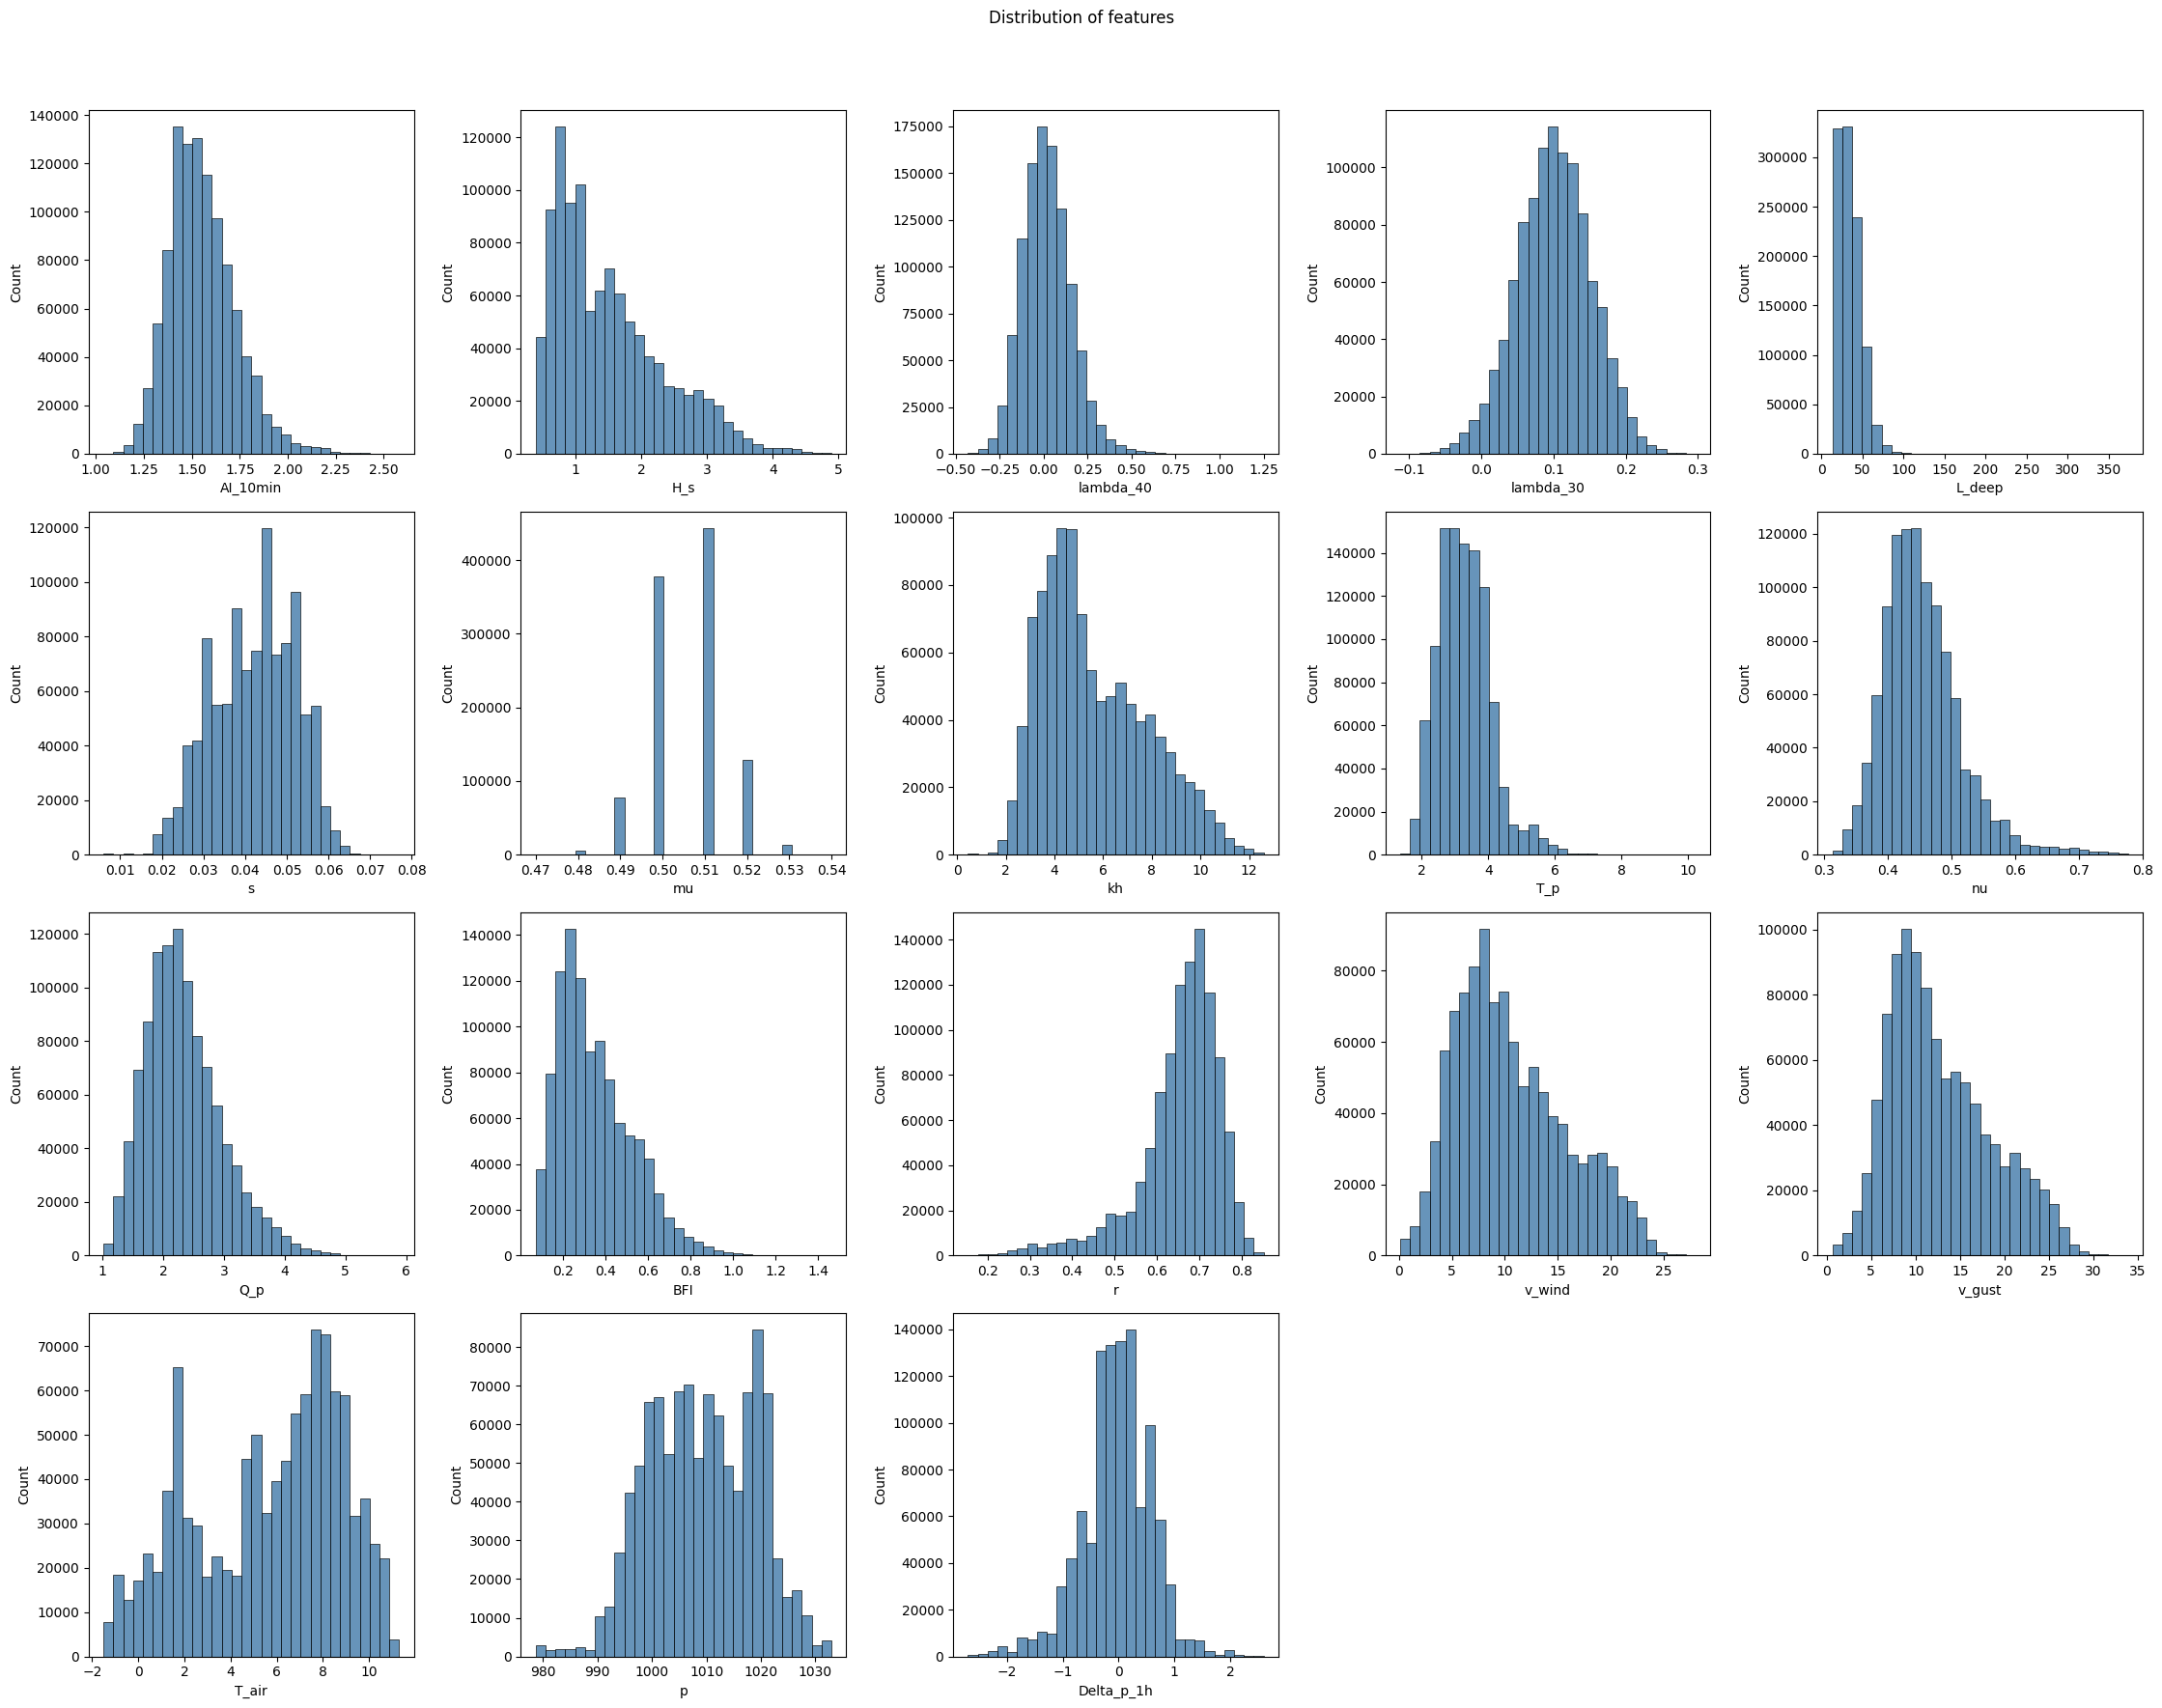

In [8]:
utils.plot_distributions(dataset=data_rogue_waves, ncols=5)

**Train/Test Splitting Strategy**

In [9]:
# Define thresholds for three classes
threshold_1 = 1.5
threshold_2 = 2.0

# Binarize target 
data_rogue_waves_class = data_rogue_waves.copy()
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target].apply(lambda x: 0 if x < threshold_1 else (1 if x < threshold_2 else 2))
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target_cat].astype(int)

print('Dataset target distribution:')
print(Counter(data_rogue_waves_class[target_cat]))

Dataset target distribution:
Counter({1: 611931, 0: 418636, 2: 17830})


In [10]:
# split into train and test data
data_train, data_test = train_test_split(data_rogue_waves_class, stratify=data_rogue_waves_class[target_cat], train_size=0.80, random_state=seed)

data_train.reset_index(inplace=True, drop=True)
data_test.reset_index(inplace=True, drop=True)

print('Training dataset target distribution:')
print(Counter(data_train[target_cat]))

print('Test dataset target distribution:')
print(Counter(data_test[target_cat]))

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})
Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


**Save Processed Dataset**

In [14]:
# Save the data 
data = [data_train, data_test]

with open(f'../data/data_train_test.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)